# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N°3: Estrategias de muestreo de puntos de colocación

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from pyDOE import lhs

In [2]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [3]:
def get_ds_data(pressure_ds, velocity_ds, n):
    idxs = [random.randrange(0, len(pressure_raw_data['x'][0])) for _ in range(n)]
    xy = []
    labels = []
    for idx in idxs:
        assert pressure_ds['x'][0][idx] == velocity_ds['x'][0][idx]
        assert pressure_ds['y'][0][idx] == velocity_ds['y'][0][idx]
        xy.append([pressure_ds['x'][0][idx], pressure_ds['y'][0][idx]])
        labels.append([velocity_ds['u'][0][idx], velocity_ds['v'][0][idx], pressure_ds['p'][0][idx]])
    return np.array(xy), np.array(labels)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
 class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Reynolds = model_parameters["Reynolds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        self.init_xavier()
        
    def init_xavier(self):
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)
        self.apply(init_weights)

    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def pdeResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0:1]
        v = output[:,1:2]
        p = output[:,2:3]
        
        # Compute the derivatives of the outputs u,v and p over the inputs (x,y) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        u_x, u_y = diff_u[:, 0:1], diff_u[:, 1:2]
        v_x, v_y = diff_v[:, 0:1], diff_v[:, 1:2]
        p_x, p_y = diff_p[:, 0:1], diff_p[:, 1:2]

        # Compute the second derivative of the outputs u and v over the inputs (x,y) using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Compute residues
        residue_continuity = u_x + v_y
        residue_momentum_x = u * u_x + v * u_y + p_x - (1/self.Reynolds) * (u_xx + u_yy)
        residue_momentum_y = u * v_x + v * v_y + p_y - (1/self.Reynolds) * (v_xx + v_yy)
        return residue_continuity, residue_momentum_x, residue_momentum_y

    def bcUVResidue(self, X, output):
        # Separate u and v from the output
        u = output[:,0:1]
        v = output[:,1:2]
        # Calculate true bc values 
        u_bc = (X[:,1:2] == 1) * 1.0 # u = 1 only at upper y bound, else 0
        residue_u = u - u_bc
        residue_v = v # v = 0 on all border
        return residue_u, residue_v

    def bcPResidue(self, X, output):
        # Separate p from the output
        p = output[:,2:3]
        residue_p = p # p = 0 on the origin
        return residue_p

In [6]:
# Shared model parameters
model_parameters = {
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 100,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.GELU()
}
n_datasets = [(1_000, 100), (10_000, 1_000), (50_000, 5_000)]
epochs = 10_000
lr = 1e-3

# Shared ground truth
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, 10)
X_data_random = torch.tensor(xy_data_random).float().to(device)
Y_data_random = torch.tensor(labels_data_random).float().to(device)

In [7]:
def train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data):
    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = (loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y) / 3
    
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = loss_bc_u * 10 + loss_bc_v * 10 + loss_bc_p * 100
    
    #Loss data
    y_hat_data = model(X_data)
    loss_data = loss_fn(y_hat_data, Y_data)
    
    return loss_pde, loss_bc, loss_data

### Muestreo aleatorio uniforme

In [8]:
def get_xy_pde_random(x_bounds, y_bounds, n):
    x = np.random.uniform(np.nextafter(x_bounds[0], x_bounds[1]), x_bounds[1], n)
    y = np.random.uniform(np.nextafter(y_bounds[0], y_bounds[1]), y_bounds[1], n)
    return np.array([[x[i], y[i]] for i in range(n)])

In [9]:
def get_xy_bc_random(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        elif side == 'right':
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        else:  # side == 'left'
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[0]])
    return np.array(xy)

In [46]:
rand_mse_error = []

print("Random Sample Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None

    xy_pde_random = get_xy_pde_random([0, 1], [0, 1], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([0, 1], [0, 1], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data_random, Y_data_random)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()

        # Checkpoint best model
        if loss_overall.item() < best_val_loss:
            best_val_loss = loss_overall.item()
            best_model_state = model.state_dict()

        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e}")

    # Calculate error
    model.load_state_dict(best_model_state)
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rand_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Cleanup
    del(X_data)
    del(output_data)
    torch.cuda.empty_cache()

Random Sample Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.5610e-01, PDE: 6.4406e-03, BC: 1.3110e-01, Data: 1.8560e-02
Epoch 1000/10000 - Loss Overall: 1.2136e-01, PDE: 6.8582e-03, BC: 1.0141e-01, Data: 1.3091e-02
Epoch 1500/10000 - Loss Overall: 1.0747e-01, PDE: 1.2274e-02, BC: 8.3569e-02, Data: 1.1622e-02
Epoch 2000/10000 - Loss Overall: 9.6922e-02, PDE: 1.4726e-02, BC: 7.1212e-02, Data: 1.0984e-02
Epoch 2500/10000 - Loss Overall: 1.2912e-01, PDE: 1.7962e-02, BC: 1.0066e-01, Data: 1.0497e-02
Epoch 3000/10000 - Loss Overall: 8.0673e-02, PDE: 1.6236e-02, BC: 5.5411e-02, Data: 9.0258e-03
Epoch 3500/10000 - Loss Overall: 6.2019e-02, PDE: 1.7023e-02, BC: 3.7469e-02, Data: 7.5264e-03
Epoch 4000/10000 - Loss Overall: 4.9527e-02, PDE: 1.4303e-02, BC: 2.8685e-02, Data: 6.5394e-03
Epoch 4500/10000 - Loss Overall: 4.0786e-02, PDE: 1.2841e-02, BC: 2.2373e-02, Data: 5.5716e-03
Epoch 5000/10000 - Loss Overall: 3.1506e-02, PDE: 1.0425e-02, BC: 1.7078e-02, Data: 4.0035e-03
Epoch 5500/10000 - Loss Overall: 2.3634e-02, PDE: 8

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.7663e-01, PDE: 7.9538e-03, BC: 1.5298e-01, Data: 1.5699e-02
Epoch 1000/10000 - Loss Overall: 1.3009e-01, PDE: 1.1550e-02, BC: 1.0773e-01, Data: 1.0809e-02
Epoch 1500/10000 - Loss Overall: 1.1904e-01, PDE: 1.5539e-02, BC: 9.4142e-02, Data: 9.3536e-03
Epoch 2000/10000 - Loss Overall: 1.0235e-01, PDE: 1.6199e-02, BC: 7.8365e-02, Data: 7.7841e-03
Epoch 2500/10000 - Loss Overall: 8.5477e-02, PDE: 1.3595e-02, BC: 6.6365e-02, Data: 5.5160e-03
Epoch 3000/10000 - Loss Overall: 7.8393e-02, PDE: 1.3800e-02, BC: 6.0370e-02, Data: 4.2226e-03
Epoch 3500/10000 - Loss Overall: 6.9472e-02, PDE: 1.2917e-02, BC: 5.3422e-02, Data: 3.1321e-03
Epoch 4000/10000 - Loss Overall: 6.2716e-02, PDE: 1.1918e-02, BC: 4.8609e-02, Data: 2.1888e-03
Epoch 4500/10000 - Loss Overall: 5.8089e-02, PDE: 1.1750e-02, BC: 4.4833e-02, Data: 1.5058e-03
Epoch 5000/10000 - Loss Overall: 5.2075e-02, PDE: 8.6507e-03, BC: 4.2467e-02, Data: 9.5744e-04
Epoch 5500/10000 - Loss Overall: 4.5879e-02, PDE: 7

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.7457e-01, PDE: 8.3451e-03, BC: 1.5006e-01, Data: 1.6163e-02
Epoch 1000/10000 - Loss Overall: 1.2664e-01, PDE: 1.2451e-02, BC: 1.0366e-01, Data: 1.0527e-02
Epoch 1500/10000 - Loss Overall: 1.0609e-01, PDE: 1.8069e-02, BC: 7.9421e-02, Data: 8.5973e-03
Epoch 2000/10000 - Loss Overall: 9.0658e-02, PDE: 1.4865e-02, BC: 6.8598e-02, Data: 7.1953e-03
Epoch 2500/10000 - Loss Overall: 8.1685e-02, PDE: 1.4007e-02, BC: 6.2085e-02, Data: 5.5932e-03
Epoch 3000/10000 - Loss Overall: 7.2677e-02, PDE: 1.3416e-02, BC: 5.5048e-02, Data: 4.2129e-03
Epoch 3500/10000 - Loss Overall: 6.4167e-02, PDE: 1.2015e-02, BC: 4.8864e-02, Data: 3.2880e-03
Epoch 4000/10000 - Loss Overall: 5.7049e-02, PDE: 1.1167e-02, BC: 4.3414e-02, Data: 2.4678e-03
Epoch 4500/10000 - Loss Overall: 5.8219e-02, PDE: 9.7548e-03, BC: 4.6845e-02, Data: 1.6184e-03
Epoch 5000/10000 - Loss Overall: 4.6110e-02, PDE: 9.0646e-03, BC: 3.5781e-02, Data: 1.2643e-03
Epoch 5500/10000 - Loss Overall: 4.5325e-02, PDE: 7

### Hipercubo Latino (LHS)

In [18]:
def get_xy_pde_lhs(x_bounds, y_bounds, n):
    x = x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, n)[:,0]
    y = y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, n)[:,0]
    return np.array([[x[i], y[i]] for i in range(n)])

In [19]:
def get_xy_bc_lhs(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        elif side == 'right':
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        else:  # side == 'left'
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[0]])
    return np.array(xy)

In [49]:
lhs_mse_error = []

print("Latin hypercube sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None

    xy_pde_lhs = get_xy_pde_lhs([0, 1], [0, 1], n_pde)
    X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
    xy_bc_lhs = get_xy_bc_lhs([0, 1], [0, 1], n_bc)
    X_bc = torch.tensor(xy_bc_lhs).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data_random, Y_data_random)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        # Checkpoint best model
        if loss_overall.item() < best_val_loss:
            best_val_loss = loss_overall.item()
            best_model_state = model.state_dict()

        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e}")

    # Calculate error
    model.load_state_dict(best_model_state)
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    lhs_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Cleanup
    del(X_data)
    del(output_data)
    torch.cuda.empty_cache()

Latin hypercube sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.4467e-01, PDE: 1.4322e-02, BC: 1.1545e-01, Data: 1.4894e-02
Epoch 1000/10000 - Loss Overall: 7.5831e-02, PDE: 1.7931e-02, BC: 4.7101e-02, Data: 1.0798e-02
Epoch 1500/10000 - Loss Overall: 5.3431e-02, PDE: 1.6085e-02, BC: 2.8731e-02, Data: 8.6141e-03
Epoch 2000/10000 - Loss Overall: 4.4437e-02, PDE: 1.5717e-02, BC: 2.1068e-02, Data: 7.6514e-03
Epoch 2500/10000 - Loss Overall: 3.7595e-02, PDE: 1.4141e-02, BC: 1.6594e-02, Data: 6.8603e-03
Epoch 3000/10000 - Loss Overall: 3.5555e-02, PDE: 1.2778e-02, BC: 1.6660e-02, Data: 6.1166e-03
Epoch 3500/10000 - Loss Overall: 3.1981e-02, PDE: 1.1429e-02, BC: 1.5267e-02, Data: 5.2857e-03
Epoch 4000/10000 - Loss Overall: 2.5670e-02, PDE: 1.0211e-02, BC: 1.0903e-02, Data: 4.5568e-03
Epoch 4500/10000 - Loss Overall: 2.9390e-02, PDE: 8.5096e-03, BC: 1.7506e-02, Data: 3.3737e-03
Epoch 5000/10000 - Loss Overall: 1.9521e-02, PDE: 8.2267e-03, BC: 8.5023e-03, Data: 2.7924e-03
Epoch 5500/10000 - Loss Overall: 1.7460e-02, PDE: 7

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.9184e-01, PDE: 8.2400e-03, BC: 1.6706e-01, Data: 1.6543e-02
Epoch 1000/10000 - Loss Overall: 2.5382e-01, PDE: 1.0864e-02, BC: 2.2692e-01, Data: 1.6037e-02
Epoch 1500/10000 - Loss Overall: 1.1349e-01, PDE: 1.5767e-02, BC: 8.8069e-02, Data: 9.6565e-03
Epoch 2000/10000 - Loss Overall: 9.9319e-02, PDE: 1.6011e-02, BC: 7.4634e-02, Data: 8.6743e-03
Epoch 2500/10000 - Loss Overall: 9.1516e-02, PDE: 1.8839e-02, BC: 6.5752e-02, Data: 6.9252e-03
Epoch 3000/10000 - Loss Overall: 1.1604e-01, PDE: 3.8890e-02, BC: 7.1890e-02, Data: 5.2586e-03
Epoch 3500/10000 - Loss Overall: 6.9853e-02, PDE: 1.3726e-02, BC: 5.0780e-02, Data: 5.3461e-03
Epoch 4000/10000 - Loss Overall: 6.6367e-02, PDE: 1.3862e-02, BC: 4.7812e-02, Data: 4.6937e-03
Epoch 4500/10000 - Loss Overall: 6.0267e-02, PDE: 1.2250e-02, BC: 4.3754e-02, Data: 4.2631e-03
Epoch 5000/10000 - Loss Overall: 5.9485e-02, PDE: 1.3011e-02, BC: 4.3090e-02, Data: 3.3833e-03
Epoch 5500/10000 - Loss Overall: 5.2090e-02, PDE: 1

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.8232e-01, PDE: 7.6951e-03, BC: 1.5912e-01, Data: 1.5497e-02
Epoch 1000/10000 - Loss Overall: 1.5008e-01, PDE: 9.4819e-03, BC: 1.2967e-01, Data: 1.0932e-02
Epoch 1500/10000 - Loss Overall: 1.3604e-01, PDE: 1.3698e-02, BC: 1.1255e-01, Data: 9.7875e-03
Epoch 2000/10000 - Loss Overall: 1.2401e-01, PDE: 1.5387e-02, BC: 9.9591e-02, Data: 9.0339e-03
Epoch 2500/10000 - Loss Overall: 1.1074e-01, PDE: 1.7485e-02, BC: 8.5846e-02, Data: 7.4127e-03
Epoch 3000/10000 - Loss Overall: 9.4806e-02, PDE: 1.3949e-02, BC: 7.5361e-02, Data: 5.4960e-03
Epoch 3500/10000 - Loss Overall: 8.5272e-02, PDE: 1.3577e-02, BC: 6.7498e-02, Data: 4.1959e-03
Epoch 4000/10000 - Loss Overall: 7.5390e-02, PDE: 1.2269e-02, BC: 6.0417e-02, Data: 2.7038e-03
Epoch 4500/10000 - Loss Overall: 6.7747e-02, PDE: 1.1912e-02, BC: 5.4312e-02, Data: 1.5234e-03
Epoch 5000/10000 - Loss Overall: 6.2966e-02, PDE: 1.0699e-02, BC: 5.1360e-02, Data: 9.0733e-04
Epoch 5500/10000 - Loss Overall: 5.1903e-02, PDE: 8

### Muestreo adaptativo basado en residuos (RAD)

In [75]:
def get_xy_pde_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 3):
    xy_pde_base = get_xy_pde_random(x_bounds, y_bounds, n * oversampling)
    X_pde_base = torch.tensor(xy_pde_base, requires_grad = True).float().to(device)
    output_pde = model(X_pde_base)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde_base, output_pde)
    epsilon = torch.pow(torch.abs(residue_momentum_x), k) + torch.pow(torch.abs(residue_momentum_y), k)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
    idx = np.random.choice(a=len(X_pde_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_pde_base[idx.flatten(), :].cpu().detach().numpy()

In [76]:
def get_xy_bc_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 3):
    xy_bc_base = get_xy_bc_random(x_bounds, y_bounds, n * oversampling)
    X_bc_base = torch.tensor(xy_bc_base).float().to(device)
    output_bc = model(X_bc_base)
    residue_u, residue_v = model.bcUVResidue(X_bc_base, output_bc)
    epsilon = torch.pow(torch.abs(residue_u), k) + torch.pow(torch.abs(residue_v), k)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
    idx = np.random.choice(a=len(X_bc_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_bc_base[idx.flatten(), :].cpu().detach().numpy()

In [89]:
rad_mse_error = []

print("Residual-based Adaptative Distribution sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    model = PINN_Module(model_parameters).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None

    xy_pde_random = get_xy_pde_random([0, 1], [0, 1], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([0, 1], [0, 1], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        # RAD strategy
        if epoch % (epochs/10) == 0 and epoch!=0:
            xy_pde_rad = get_xy_pde_rad([0, 1], [0, 1], n_pde, model)
            X_pde = torch.tensor(xy_pde_rad, requires_grad = True).float().to(device)
            xy_bc_rad = get_xy_bc_rad([0, 1], [0, 1], n_bc, model)
            X_bc = torch.tensor(xy_bc_rad).float().to(device)
            tqdm.write(f"New dataset sampling based on RAD strategy")
            torch.cuda.empty_cache()
        
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data_random, Y_data_random)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        # Checkpoint best model
        if loss_overall.item() < best_val_loss:
            best_val_loss = loss_overall.item()
            best_model_state = model.state_dict()

        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e}")

    # Calculate error
    model.load_state_dict(best_model_state)
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rad_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Cleanup
    del(X_data)
    del(output_data)
    torch.cuda.empty_cache()

Residual-based Adaptative Distribution sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 2.0222e-01, PDE: 9.1718e-03, BC: 1.7659e-01, Data: 1.6462e-02
Epoch 1000/10000 - Loss Overall: 1.4897e-01, PDE: 1.3799e-02, BC: 1.2173e-01, Data: 1.3433e-02
New dataset sampling based on RAD strategy
Epoch 1500/10000 - Loss Overall: 3.5273e-01, PDE: 3.7263e-02, BC: 3.0534e-01, Data: 1.0121e-02
Epoch 2000/10000 - Loss Overall: 3.0525e-01, PDE: 3.4034e-02, BC: 2.6162e-01, Data: 9.6000e-03
New dataset sampling based on RAD strategy
Epoch 2500/10000 - Loss Overall: 1.1493e-01, PDE: 1.8841e-02, BC: 8.8580e-02, Data: 7.5115e-03
Epoch 3000/10000 - Loss Overall: 1.0934e-01, PDE: 2.0693e-02, BC: 8.1773e-02, Data: 6.8773e-03
New dataset sampling based on RAD strategy
Epoch 3500/10000 - Loss Overall: 1.5319e-01, PDE: 2.3083e-02, BC: 1.2407e-01, Data: 6.0356e-03
Epoch 4000/10000 - Loss Overall: 1.2859e-01, PDE: 2.0918e-02, BC: 1.0304e-01, Data: 4.6361e-03
New dataset sampling based on RAD strategy
Epoch 4500/10000 - Loss Overall: 1.1529e-01, PDE: 2.6389e-02, BC: 8.5

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.8200e-01, PDE: 7.6432e-03, BC: 1.6159e-01, Data: 1.2767e-02
Epoch 1000/10000 - Loss Overall: 1.4446e-01, PDE: 1.1782e-02, BC: 1.2296e-01, Data: 9.7245e-03
New dataset sampling based on RAD strategy
Epoch 1500/10000 - Loss Overall: 2.7640e-01, PDE: 2.4924e-02, BC: 2.4240e-01, Data: 9.0786e-03
Epoch 2000/10000 - Loss Overall: 1.6987e-01, PDE: 2.6590e-02, BC: 1.3651e-01, Data: 6.7631e-03
New dataset sampling based on RAD strategy
Epoch 2500/10000 - Loss Overall: 1.7863e-01, PDE: 2.9056e-02, BC: 1.4395e-01, Data: 5.6180e-03
Epoch 3000/10000 - Loss Overall: 1.7324e-01, PDE: 3.0466e-02, BC: 1.3826e-01, Data: 4.5216e-03
New dataset sampling based on RAD strategy
Epoch 3500/10000 - Loss Overall: 1.2367e-01, PDE: 2.0194e-02, BC: 1.0045e-01, Data: 3.0298e-03
Epoch 4000/10000 - Loss Overall: 1.1160e-01, PDE: 1.7836e-02, BC: 9.2491e-02, Data: 1.2708e-03
New dataset sampling based on RAD strategy
Epoch 4500/10000 - Loss Overall: 1.2533e-01, PDE: 1.3866e-02, BC: 1.1

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500/10000 - Loss Overall: 1.6371e-01, PDE: 5.7299e-03, BC: 1.4495e-01, Data: 1.3030e-02
Epoch 1000/10000 - Loss Overall: 1.2499e-01, PDE: 9.1554e-03, BC: 1.0556e-01, Data: 1.0275e-02
New dataset sampling based on RAD strategy
Epoch 1500/10000 - Loss Overall: 2.1895e-01, PDE: 2.3979e-02, BC: 1.8607e-01, Data: 8.8919e-03
Epoch 2000/10000 - Loss Overall: 1.7613e-01, PDE: 2.5575e-02, BC: 1.4359e-01, Data: 6.9670e-03
New dataset sampling based on RAD strategy
Epoch 2500/10000 - Loss Overall: 1.6787e-01, PDE: 2.6880e-02, BC: 1.3593e-01, Data: 5.0639e-03
Epoch 3000/10000 - Loss Overall: 1.4808e-01, PDE: 2.3667e-02, BC: 1.2022e-01, Data: 4.1969e-03
New dataset sampling based on RAD strategy
Epoch 3500/10000 - Loss Overall: 1.4870e-01, PDE: 2.4897e-02, BC: 1.2082e-01, Data: 2.9809e-03
Epoch 4000/10000 - Loss Overall: 1.4167e-01, PDE: 2.2192e-02, BC: 1.1733e-01, Data: 2.1506e-03
New dataset sampling based on RAD strategy
Epoch 4500/10000 - Loss Overall: 1.2841e-01, PDE: 2.1737e-02, BC: 1.0

### Grafica error vs tamaño del dataset

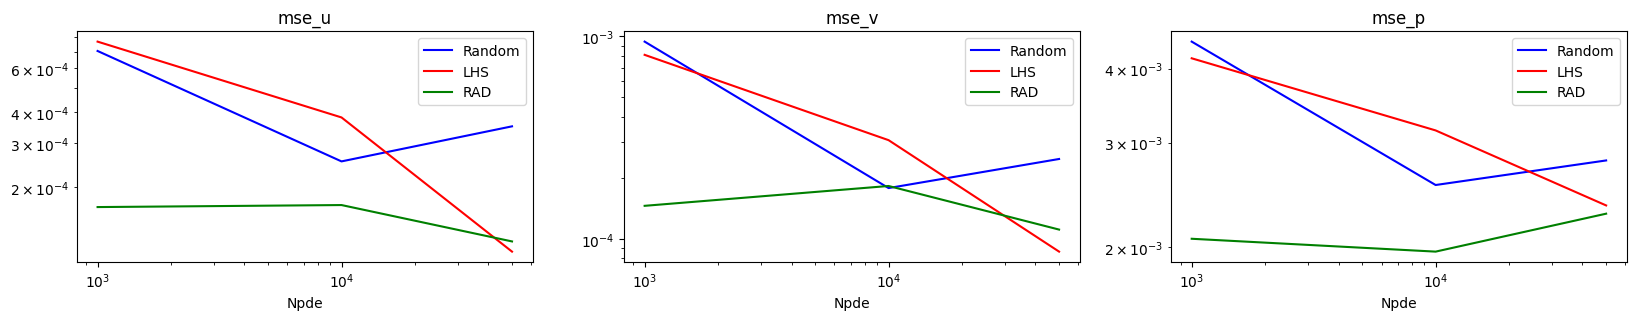

In [90]:
n_datasets
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['mse_u', 'mse_v', 'mse_p']):
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rand_mse_error], color='blue', label='Random')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in lhs_mse_error], color='red', label='LHS')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rad_mse_error], color='green', label='RAD')
    ax[i].set_xlabel('Npde')
    ax[i].set_title(f"{title}")
    ax[i].legend()
plt.show()

### Conclusiones

- Para el último tamaño del dataset se utilizaron 50.000/5.000 muestras por restricciones del hardware disponibles.

- A partir de la gráfica anterior, se observa una mejora apreciable de la norma-2 del error en función del tamaño del dataset para estregias random y LHS pero nó para estrategia RAD.

- La mejor performance de todas se obutvo con la estrategia de muestreo LHS con 50.000/5.000 muestras, aunque la estrategia RAD obtuvo resultados prácticamente similares

- Se observa que para estrategia random y datasets mayores a 10.000/1.000 muestras no se producen mejoras notables del error.

- Al comparar las estrategias entre si, el mejor desempeño para datasets de menor tamaño fue alcanzado por la estrategia RAD. Con datasets de mayor tamaño el error conseguido con otras estrategias comienza a asemejarse al error de la estrategia RAD.

- Las observaciones anteriores eran esperables:
    - El mejor comportamiento con datasets pequeños lo obtuvo la estrategia de RAD ya que elije los puntos críticos en cada actualización del dataset.
    - Se esperaba que las estrategias random y LHS reporten una mejora notable del error con el aumento del tamaño del dataset, mientras que para la estrategia RAD el aumento no fuera tan notable.
    - Finalmente no se esperaba que el mejor error se obtuviese con estrategia LHS, aunque RAD obtuvo resultados prácticamente similares. Se estima que esto se debió a las condiciones aleatorias del experimento específico y no a bondades del método de elección de las muestras.